![title](https://segundoasegundo.com/wp-content/uploads/2019/03/Semana-Santa-850x370.png)

# <center> Conociendo la oferta gastron칩mica y tur칤stica de la ciudad de Guadalajara: un pr치ctico caso de Data Intelligence y Machine Learning para el an치lisis del comportamiento social con Google Maps</center>

 <center> <a href="http://www.roqueleal.me">Roque Leal</a> </center>

En esta oportunidad vamos a realizar un estudio exploratorio de los datos de Google Maps asociados a la ciudad de Guadalajara - M칠xico, para ello se utilizar치 la extracci칩n de los datos en Google Maps para descubrir datos 칰tiles sobre los restaurantes 칩 de sus atracciones tur칤sticas:nombres, tipos de negocios, clasificaciones de estrellas, informaci칩n de contacto, coordenadas, horarios m치s frecuentados, etc.

Todos estos datos se pueden utilizar para obtener muchos conocimientos sobre el negocio / ubicaci칩n y sus entornos circundantes, para ello comencemos este paseo con algo de lo m치s t칤pico de Guadalajara: su gastron칩mia y sus atracciones tur칤sticas para descubrir interesantes Geoinsights de los restaurantes, mejorar la experiencia de los clientes, conocer su comportamiento y responder a nuestra curiosidad de conocer lo mejor que la ciudad nos ofrece de una manera inteligente con BigData y Data Science.

## Librerias Python

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementNotInteractableException, ElementClickInterceptedException
from tqdm import tqdm_notebook as tqdmn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import time, re

In [12]:
resto.shape

(176, 12)

In [2]:
resto = pd.read_csv('gdl_resto.csv')

In [3]:
resto.head()

full_name  rating total_ratings   business_category  \
0                         TACOS GAY     4.0         (251)  Mexican restaurant   
1               Tortas Ahogadas Moy     4.9          (54)  Mexican restaurant   
2          Birrier칤a las 9 Esquinas     4.4       (6,434)  Mexican restaurant   
3          EL PILON DE LOS ARRIEROS     4.6       (1,299)  Mexican restaurant   
4  Los Dichos de la Comida Mexicana     4.4         (805)  Mexican restaurant   

  price_range                               address phone  \
0           $  MMF2+35 Guadalajara, Jalisco, Mexico   NaN   
1         NaN  MMF3+7Q Guadalajara, Jalisco, Mexico   NaN   
2          $$  MMC2+8G Guadalajara, Jalisco, Mexico   NaN   
3          $$  MMC2+7F Guadalajara, Jalisco, Mexico   NaN   
4          $$  MMF3+99 Guadalajara, Jalisco, Mexico   NaN   

               website                                      review_topics  \
0                  NaN  ['wealth\n13', 'kindness\n7', 'supper\n6', 'ev...   
1                  NaN                                                 []   
2     +52 33 3613 6260  ['birria\n1248', 'traditional\n141', 'goat\n11...   
3     +52 33 3613 2799  ['birria\n183', 'cymbals\n51', 'barbacoa\n38',...   
4  Claim this business  ['economy\n17', 'breakfast\n16', 'aguas fresca...   

                                               hours   latitude   longitude  
0  ['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...  20.672726 -103.349527  
1                                                 []  20.673163 -103.345601  
2  ['0% busy at 6 AM.', '0% busy at 7 AM.', '16% ...  20.670800 -103.348681  
3  ['0% busy at 6 AM.', '0% busy at 7 AM.', '4% b...  20.670644 -103.348760  
4  ['0% busy at 6 AM.', '0% busy at 7 AM.', '21% ...  20.673388 -103.346591

In [4]:
resto.shape

(176, 12)

## Esta t칠cnica nos permiti칩 extraer datos de 176 restaurantes del centro de la ciudad de Guadalajara

In [5]:
resto.total_ratings = resto.total_ratings.replace('(\(|\)|,)', '', regex=True)

In [6]:
resto.total_ratings = resto.total_ratings.astype(float)

In [7]:
resto.business_category.value_counts()

Mexican restaurant              135
Taco restaurant                   8
Restaurant                        6
Bar & grill                       5
Fast food restaurant              3
Bar                               2
Down home cooking restaurant      2
Market                            2
Chicken restaurant                2
Health food restaurant            1
Takeout restaurant                1
Department store                  1
Buffet restaurant                 1
Vegan restaurant                  1
Seafood restaurant                1
Hamburger restaurant              1
Name: business_category, dtype: int64

In [8]:
resto = resto[resto.business_category.isin(['Mexican restaurant'])].copy()

In [9]:
resto.business_category.value_counts()

Mexican restaurant    135
Name: business_category, dtype: int64

## Vamos a localizar nuestra muestra de 211 restaurantes en Guadalajara

In [10]:
tileset = r'https://api.mapbox.com/styles/v1/roqueleal08/cjyaey84d07zq1crze5r08yg1/tiles/256/{z}/{x}/{y}@2x?access_token=MAPBOXAPI'
attribution = (r'Map data 춸 <a href="http://openstreetmap.org">OpenStreetMap</a>'
                ' contributors, Imagery 춸 <a href="http://mapbox.com">MapBox</a>')
gdl_center = [20.665072,-103.348904]
resto_map = folium.Map(location=gdl_center, zoom_start=12.5, tiles=tileset, attr=attribution)

for latitude, longitude, full_name, address, phone, website, rating, total_rating in zip(resto.latitude, resto.longitude, resto.full_name, resto.address, resto.phone, resto.website, resto.rating, resto.total_ratings):
    popup = '<strong>' + str(full_name) +  '</li><li>Rating: ' + str(rating) + ' (Total of ' + str(total_rating) + ' reviews)'
    folium.Marker( [latitude, longitude], 
                   icon=folium.CustomIcon( icon_image='https://www.pinclipart.com/picdir/big/46-460577_maps-vector-graphic-google-maps-icon-android-clipart.png', icon_size=(15,15) ), popup=popup).add_to(resto_map)
resto_map

In [11]:
from folium.plugins import HeatMap
resto_rating = resto[resto.total_ratings>400].copy()
resto_rating['count'] = 1

## Hacemos un Heatmap con los de mejor puntaje en la ciudad

In [12]:
HeatMap(data=resto_rating[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=20, max_zoom=17).add_to(resto_map)
resto_map

In [13]:
resto_rating.head().sort_values(by='total_ratings', ascending=False)

full_name  rating  total_ratings  \
2          Birrier칤a las 9 Esquinas     4.4         6434.0   
6    Restaurantes La Gorda 췅 Centro     4.2         2551.0   
3          EL PILON DE LOS ARRIEROS     4.6         1299.0   
4  Los Dichos de la Comida Mexicana     4.4          805.0   
7             BIRRIERIA EL COMPADRE     4.5          432.0   

    business_category price_range                               address phone  \
2  Mexican restaurant          $$  MMC2+8G Guadalajara, Jalisco, Mexico   NaN   
6  Mexican restaurant          $$  MMF3+HF Guadalajara, Jalisco, Mexico   NaN   
3  Mexican restaurant          $$  MMC2+7F Guadalajara, Jalisco, Mexico   NaN   
4  Mexican restaurant          $$  MMF3+99 Guadalajara, Jalisco, Mexico   NaN   
7  Mexican restaurant          $$  MMC2+4G Guadalajara, Jalisco, Mexico   NaN   

               website                                      review_topics  \
2     +52 33 3613 6260  ['birria\n1248', 'traditional\n141', 'goat\n11...   
6     +52 33 3613 7185  ['pozole\n80', 'cymbals\n68', 'carne en su jug...   
3     +52 33 3613 2799  ['birria\n183', 'cymbals\n51', 'barbacoa\n38',...   
4  Claim this business  ['economy\n17', 'breakfast\n16', 'aguas fresca...   
7     +52 33 3614 5550  ['birria\n105', 'tortillas\n11', 'quesadilla\n...   

                                               hours   latitude   longitude  \
2  ['0% busy at 6 AM.', '0% busy at 7 AM.', '16% ...  20.670800 -103.348681   
6  ['0% busy at 6 AM.', '0% busy at 7 AM.', '20% ...  20.673876 -103.346340   
3  ['0% busy at 6 AM.', '0% busy at 7 AM.', '4% b...  20.670644 -103.348760   
4  ['0% busy at 6 AM.', '0% busy at 7 AM.', '21% ...  20.673388 -103.346591   
7  ['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...  20.670254 -103.348644   

   count  
2      1  
6      1  
3      1  
4      1  
7      1

## Ahora identificamos aquellos restaurantes que cumplan la condici칩n de ser restaurantes de cocina tradicional de alta calidad con una buena oferta de c칩cteles

In [14]:
resto.business_category.value_counts()

Mexican restaurant    135
Name: business_category, dtype: int64

In [15]:
mexican = resto[resto.business_category == 'Mexican restaurant']
restaurants  = resto[(resto.business_category.str.contains('Restaurant', case=False)) & (resto.full_name.str.contains('Mexican restaurant', case=False, regex=True))]

gdl_resto = pd.concat([mexican, restaurants])

In [16]:
gdl_resto.head(1)

full_name  rating  total_ratings   business_category price_range  \
0  TACOS GAY     4.0          251.0  Mexican restaurant           $   

                                address phone website  \
0  MMF2+35 Guadalajara, Jalisco, Mexico   NaN     NaN   

                                       review_topics  \
0  ['wealth\n13', 'kindness\n7', 'supper\n6', 'ev...   

                                               hours   latitude   longitude  
0  ['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...  20.672726 -103.349527

Aqui vemos los restaurantes que cumplen las condiciones descritas seg칰n el t칩pico de sus reviews, este hace referencia en las palabras claves que los usuarios reconocieron el local y atribuyeron sus reviews

Elegimos aquellos que cumplan la condici칩n de "traditional", "coktail" y "gourmet" para asignar un valor a cada restaurante y lograr establecer un scoring seg칰n estas condiciones

In [17]:
traditional = []
for i in gdl_resto.review_topics :
    traditional.append(re.findall('\d+|$', re.findall('traditional......|$', i)[0])[0] )

gdl_resto['traditional'] = traditional

cocktail = []
for i in gdl_resto.review_topics :
    cocktail.append(re.findall('\d+|$', re.findall('cocktail......|$', i)[0])[0] )

gdl_resto['cocktail'] = cocktail

gourmet = []
for i in gdl_resto.review_topics :
    gourmet.append(re.findall('\d+|$', re.findall('gourmet......|$', i)[0])[0] )

gdl_resto['gourmet'] = gourmet

In [18]:
gdl_resto.head(20)

full_name  rating  total_ratings  \
0                           TACOS GAY     4.0          251.0   
1                 Tortas Ahogadas Moy     4.9           54.0   
2            Birrier칤a las 9 Esquinas     4.4         6434.0   
3            EL PILON DE LOS ARRIEROS     4.6         1299.0   
4    Los Dichos de la Comida Mexicana     4.4          805.0   
5      Tacos y Gorditas El Gallo Chuy     4.5          245.0   
6      Restaurantes La Gorda 췅 Centro     4.2         2551.0   
7               BIRRIERIA EL COMPADRE     4.5          432.0   
8          Tortas Ahogadas Don Albert     4.5          328.0   
9              CARNITAS SAN FRANCISCO     4.5          288.0   
10  Carnitas Uruapan | Nueve Esquinas     4.3          675.0   
11            Restaurant Santa Martha     4.2          139.0   
13                    Restaurant Mary     4.4           86.0   
14                           La Chata     4.6        10535.0   
15     El Ahogacentro Tortas Ahogadas     4.5          426.0   
17                   Tortas Degollado     4.2          331.0   
18                          Los Arcos     4.5          133.0   
19                   Tortas Degollado     4.2          331.0   
20                      Casa Bariachi     4.4         6788.0   
21            Papa Caba침a Chapultepec     4.1          630.0   

     business_category price_range                               address  \
0   Mexican restaurant           $  MMF2+35 Guadalajara, Jalisco, Mexico   
1   Mexican restaurant         NaN  MMF3+7Q Guadalajara, Jalisco, Mexico   
2   Mexican restaurant          $$  MMC2+8G Guadalajara, Jalisco, Mexico   
3   Mexican restaurant          $$  MMC2+7F Guadalajara, Jalisco, Mexico   
4   Mexican restaurant          $$  MMF3+99 Guadalajara, Jalisco, Mexico   
5   Mexican restaurant         NaN  MMF3+GR Guadalajara, Jalisco, Mexico   
6   Mexican restaurant          $$  MMF3+HF Guadalajara, Jalisco, Mexico   
7   Mexican restaurant          $$  MMC2+4G Guadalajara, Jalisco, Mexico   
8   Mexican restaurant           $  MJFW+4J Guadalajara, Jalisco, Mexico   
9   Mexican restaurant           $  MMC3+M2 Guadalajara, Jalisco, Mexico   
10  Mexican restaurant          $$  MMC2+9J Guadalajara, Jalisco, Mexico   
11  Mexican restaurant          $$  MMF3+89 Guadalajara, Jalisco, Mexico   
13  Mexican restaurant         NaN  MMC3+VR Guadalajara, Jalisco, Mexico   
14  Mexican restaurant          $$  MMF3+V8 Guadalajara, Jalisco, Mexico   
15  Mexican restaurant         NaN  MMF2+H5 Guadalajara, Jalisco, Mexico   
17  Mexican restaurant           $  MJ9X+4V Guadalajara, Jalisco, Mexico   
18  Mexican restaurant          $$  MMF2+65 Guadalajara, Jalisco, Mexico   
19  Mexican restaurant           $  MJ9X+4V Guadalajara, Jalisco, Mexico   
20  Mexican restaurant          $$  MJFC+JJ Guadalajara, Jalisco, Mexico   
21  Mexican restaurant          $$  MJ9J+CC Guadalajara, Jalisco, Mexico   

                  phone              website  \
0                   NaN                  NaN   
1                   NaN                  NaN   
2                   NaN     +52 33 3613 6260   
3                   NaN     +52 33 3613 2799   
4                   NaN  Claim this business   
5                   NaN     +52 33 2385 4424   
6                   NaN     +52 33 3613 7185   
7                   NaN     +52 33 3614 5550   
8                   NaN     +52 33 3613 6965   
9                   NaN                  NaN   
10                  NaN     +52 33 3614 3291   
11  Claim this business                  NaN   
13  Claim this business                  NaN   
14                  NaN     +52 33 3613 0588   
15                  NaN                  NaN   
17                  NaN     +52 33 3335 2601   
18                  NaN     +52 33 3613 3830   
19                  NaN     +52 33 3335 2601   
20                  NaN     +52 33 3616 9900   
21                  NaN     +52 33 3615 4321   

                                        review_topics  \
0   ['wealth\n13', '

In [19]:
gdl_resto.traditional = gdl_resto.traditional.replace('', 0)
gdl_resto.cocktail = gdl_resto.cocktail.replace('', 0)
gdl_resto.gourmet = gdl_resto.gourmet.replace('', 0)

In [20]:
gdl_resto.traditional = gdl_resto.traditional.astype(int)
gdl_resto.cocktail = gdl_resto.cocktail.astype(int)
gdl_resto.gourmet = gdl_resto.gourmet.astype(int)

In [21]:
gdl_resto.head(20)

full_name  rating  total_ratings  \
0                           TACOS GAY     4.0          251.0   
1                 Tortas Ahogadas Moy     4.9           54.0   
2            Birrier칤a las 9 Esquinas     4.4         6434.0   
3            EL PILON DE LOS ARRIEROS     4.6         1299.0   
4    Los Dichos de la Comida Mexicana     4.4          805.0   
5      Tacos y Gorditas El Gallo Chuy     4.5          245.0   
6      Restaurantes La Gorda 췅 Centro     4.2         2551.0   
7               BIRRIERIA EL COMPADRE     4.5          432.0   
8          Tortas Ahogadas Don Albert     4.5          328.0   
9              CARNITAS SAN FRANCISCO     4.5          288.0   
10  Carnitas Uruapan | Nueve Esquinas     4.3          675.0   
11            Restaurant Santa Martha     4.2          139.0   
13                    Restaurant Mary     4.4           86.0   
14                           La Chata     4.6        10535.0   
15     El Ahogacentro Tortas Ahogadas     4.5          426.0   
17                   Tortas Degollado     4.2          331.0   
18                          Los Arcos     4.5          133.0   
19                   Tortas Degollado     4.2          331.0   
20                      Casa Bariachi     4.4         6788.0   
21            Papa Caba침a Chapultepec     4.1          630.0   

     business_category price_range                               address  \
0   Mexican restaurant           $  MMF2+35 Guadalajara, Jalisco, Mexico   
1   Mexican restaurant         NaN  MMF3+7Q Guadalajara, Jalisco, Mexico   
2   Mexican restaurant          $$  MMC2+8G Guadalajara, Jalisco, Mexico   
3   Mexican restaurant          $$  MMC2+7F Guadalajara, Jalisco, Mexico   
4   Mexican restaurant          $$  MMF3+99 Guadalajara, Jalisco, Mexico   
5   Mexican restaurant         NaN  MMF3+GR Guadalajara, Jalisco, Mexico   
6   Mexican restaurant          $$  MMF3+HF Guadalajara, Jalisco, Mexico   
7   Mexican restaurant          $$  MMC2+4G Guadalajara, Jalisco, Mexico   
8   Mexican restaurant           $  MJFW+4J Guadalajara, Jalisco, Mexico   
9   Mexican restaurant           $  MMC3+M2 Guadalajara, Jalisco, Mexico   
10  Mexican restaurant          $$  MMC2+9J Guadalajara, Jalisco, Mexico   
11  Mexican restaurant          $$  MMF3+89 Guadalajara, Jalisco, Mexico   
13  Mexican restaurant         NaN  MMC3+VR Guadalajara, Jalisco, Mexico   
14  Mexican restaurant          $$  MMF3+V8 Guadalajara, Jalisco, Mexico   
15  Mexican restaurant         NaN  MMF2+H5 Guadalajara, Jalisco, Mexico   
17  Mexican restaurant           $  MJ9X+4V Guadalajara, Jalisco, Mexico   
18  Mexican restaurant          $$  MMF2+65 Guadalajara, Jalisco, Mexico   
19  Mexican restaurant           $  MJ9X+4V Guadalajara, Jalisco, Mexico   
20  Mexican restaurant          $$  MJFC+JJ Guadalajara, Jalisco, Mexico   
21  Mexican restaurant          $$  MJ9J+CC Guadalajara, Jalisco, Mexico   

                  phone              website  \
0                   NaN                  NaN   
1                   NaN                  NaN   
2                   NaN     +52 33 3613 6260   
3                   NaN     +52 33 3613 2799   
4                   NaN  Claim this business   
5                   NaN     +52 33 2385 4424   
6                   NaN     +52 33 3613 7185   
7                   NaN     +52 33 3614 5550   
8                   NaN     +52 33 3613 6965   
9                   NaN                  NaN   
10                  NaN     +52 33 3614 3291   
11  Claim this business                  NaN   
13  Claim this business                  NaN   
14                  NaN     +52 33 3613 0588   
15                  NaN                  NaN   
17                  NaN     +52 33 3335 2601   
18                  NaN     +52 33 3613 3830   
19                  NaN     +52 33 3335 2601   
20                  NaN     +52 33 3616 9900   
21                  NaN     +52 33 3615 4321   

                                        review_topics  \
0   ['wealth\n13', '

In [22]:
gdl_resto['score'] = gdl_resto.traditional + gdl_resto.cocktail + gdl_resto.gourmet

In [23]:
gdl_resto[((gdl_resto.traditional != 0)|(gdl_resto.cocktail != 0)) & (gdl_resto.gourmet != 0)].sort_values(by='score', ascending=False)

full_name  rating  total_ratings  \
107                    Pachuco Restaurante     4.6          752.0   
104                          El Sacromonte     4.6         1217.0   
126  Xokol tortilleria, molino & antojeria     4.6          213.0   

      business_category price_range                               address  \
107  Mexican restaurant          $$  MJGH+9R Guadalajara, Jalisco, Mexico   
104  Mexican restaurant          $$  MJGM+7H Guadalajara, Jalisco, Mexico   
126  Mexican restaurant         NaN  MJMM+7P Guadalajara, Jalisco, Mexico   

    phone           website  \
107   NaN  +52 33 2153 7071   
104   NaN  +52 33 3825 5447   
126   NaN               NaN   

                                         review_topics  \
107  ['cymbals\n58', 'cocktails\n21', 'craft beer\n...   
104  ['chiles en nogada\n70', 'cymbals\n59', 'piano...   
126  ['cymbals\n21', 'corn\n19', 'concept\n10', 'cu...   

                                                 hours   latitude   longitude  \
107  ['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...  20.675886 -103.370479   
104  ['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...  20.675737 -103.366085   
126  ['% busy at .', '% busy at .', '0% busy at 6 A...  20.683140 -103.365678   

     traditional  cocktail  gourmet  score  
107            0        21       15     36  
104           10         0       11     21  
126            7         0        8     15

## Ahora tenemos tres restaurantes que cumplen esta condici칩n el Restaurante Pachuco y El Sacromonte, sin embargo vamos a expandir m치s la oferta y seleccionar adem치s aquellos que ofrecen una buena calidad a un precio asequible

In [24]:
gdl_resto.price_range = gdl_resto.price_range.replace({'$$':'Affordable', '$$$':'Pricy' })

In [25]:
resto_best = gdl_resto.head(30).sort_values(by='score', ascending=False)

In [26]:
resto_best.head()

full_name  rating  total_ratings   business_category  \
2         Birrier칤a las 9 Esquinas     4.4         6434.0  Mexican restaurant   
14                        La Chata     4.6        10535.0  Mexican restaurant   
3         EL PILON DE LOS ARRIEROS     4.6         1299.0  Mexican restaurant   
6   Restaurantes La Gorda 췅 Centro     4.2         2551.0  Mexican restaurant   
17                Tortas Degollado     4.2          331.0  Mexican restaurant   

   price_range                               address phone           website  \
2   Affordable  MMC2+8G Guadalajara, Jalisco, Mexico   NaN  +52 33 3613 6260   
14  Affordable  MMF3+V8 Guadalajara, Jalisco, Mexico   NaN  +52 33 3613 0588   
3   Affordable  MMC2+7F Guadalajara, Jalisco, Mexico   NaN  +52 33 3613 2799   
6   Affordable  MMF3+HF Guadalajara, Jalisco, Mexico   NaN  +52 33 3613 7185   
17           $  MJ9X+4V Guadalajara, Jalisco, Mexico   NaN  +52 33 3335 2601   

                                        review_topics  \
2   ['birria\n1248', 'traditional\n141', 'goat\n11...   
14  ['gift voucher\n260', 'pozole\n238', 'torta ah...   
3   ['birria\n183', 'cymbals\n51', 'barbacoa\n38',...   
6   ['pozole\n80', 'cymbals\n68', 'carne en su jug...   
17  ['traditional\n20', 'pozole\n16', 'tostada\n15...   

                                                hours   latitude   longitude  \
2   ['0% busy at 6 AM.', '0% busy at 7 AM.', '16% ...  20.670800 -103.348681   
14  ['0% busy at 6 AM.', '5% busy at 7 AM.', '24% ...  20.674693 -103.346653   
3   ['0% busy at 6 AM.', '0% busy at 7 AM.', '4% b...  20.670644 -103.348760   
6   ['0% busy at 6 AM.', '0% busy at 7 AM.', '20% ...  20.673876 -103.346340   
17  ['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...  20.667778 -103.350278   

    traditional  cocktail  gourmet  score  
2           141         0        0    141  
14           97         0        0     97  
3            22         0        0     22  
6            21         0        0     21  
17           20         0        0     20

In [27]:
resto_best.shape

(30, 16)

## Esta nueva consulta nos permiti칩 aumentar el n칰mero de restaurantes a 30, de ellos Birrier칤a las 9 Esquinas luce el m치s atractivo para elegir y pasar una buena cena en la ciudad

## Vamos a localizar los mejores restaurantes de alta calidad en cocina tradicional con una buena oferta de c칩cteles y con precios asequibles

In [28]:
from folium.plugins import HeatMap
score = resto_best[resto_best.score>11].copy()
score['count'] = 1

In [29]:
resto_best.head()

full_name  rating  total_ratings   business_category  \
2         Birrier칤a las 9 Esquinas     4.4         6434.0  Mexican restaurant   
14                        La Chata     4.6        10535.0  Mexican restaurant   
3         EL PILON DE LOS ARRIEROS     4.6         1299.0  Mexican restaurant   
6   Restaurantes La Gorda 췅 Centro     4.2         2551.0  Mexican restaurant   
17                Tortas Degollado     4.2          331.0  Mexican restaurant   

   price_range                               address phone           website  \
2   Affordable  MMC2+8G Guadalajara, Jalisco, Mexico   NaN  +52 33 3613 6260   
14  Affordable  MMF3+V8 Guadalajara, Jalisco, Mexico   NaN  +52 33 3613 0588   
3   Affordable  MMC2+7F Guadalajara, Jalisco, Mexico   NaN  +52 33 3613 2799   
6   Affordable  MMF3+HF Guadalajara, Jalisco, Mexico   NaN  +52 33 3613 7185   
17           $  MJ9X+4V Guadalajara, Jalisco, Mexico   NaN  +52 33 3335 2601   

                                        review_topics  \
2   ['birria\n1248', 'traditional\n141', 'goat\n11...   
14  ['gift voucher\n260', 'pozole\n238', 'torta ah...   
3   ['birria\n183', 'cymbals\n51', 'barbacoa\n38',...   
6   ['pozole\n80', 'cymbals\n68', 'carne en su jug...   
17  ['traditional\n20', 'pozole\n16', 'tostada\n15...   

                                                hours   latitude   longitude  \
2   ['0% busy at 6 AM.', '0% busy at 7 AM.', '16% ...  20.670800 -103.348681   
14  ['0% busy at 6 AM.', '5% busy at 7 AM.', '24% ...  20.674693 -103.346653   
3   ['0% busy at 6 AM.', '0% busy at 7 AM.', '4% b...  20.670644 -103.348760   
6   ['0% busy at 6 AM.', '0% busy at 7 AM.', '20% ...  20.673876 -103.346340   
17  ['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...  20.667778 -103.350278   

    traditional  cocktail  gourmet  score  
2           141         0        0    141  
14           97         0        0     97  
3            22         0        0     22  
6            21         0        0     21  
17           20         0        0     20

In [30]:
HeatMap(data=score[['latitude', 'longitude', 'score']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=20, max_zoom=17).add_to(resto_map)
resto_map

## Conociendo el mejor momento para visitar nuestro restaurante

Gracias al an치lisis de la oferta gastron칩mica de Guadalajara logramos elegir la Birrier칤a las 9 Esquinas y conocemos su ubicaci칩n ahora vamos a extraer los datos de Popular Times de Google Maps para conocer el mejor horario para visitarlo.

Con Google Popular Times podemos conocer en tiempo real la ocupaci칩n de un negocio, en este caso la  Birrier칤a las 9 Esquinas, con ello es posible conocer la frecuencia de los visitantes y cu치nto tiempo suelen permanecer dentro del local.

![title](https://uploads.guim.co.uk/2016/11/22/Google-Maps-live-data-crop-compressor2.gif)


## Extraemos la frecuencia de ocupacion de la Birrier칤a las 9 Esquinas

In [31]:
str(list(resto_best[resto_best.full_name == 'Birrier칤a las 9 Esquinas'].hours))

'["[\'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'16% busy at 8 AM.\', \'39% busy at 9 AM.\', \'68% busy at 10 AM.\', \'92% busy at 11 AM.\', \'100% busy at 12 PM.\', \'92% busy at 1 PM.\', \'84% busy at 2 PM.\', \'86% busy at 3 PM.\', \'88% busy at 4 PM.\', \'80% busy at 5 PM.\', \'59% busy at 6 PM.\', \'34% busy at 7 PM.\', \'15% busy at 8 PM.\', \'0% busy at 9 PM.\', \'0% busy at 10 PM.\', \'0% busy at 11 PM.\', \'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'13% busy at 8 AM.\', \'28% busy at 9 AM.\', \'44% busy at 10 AM.\', \'52% busy at 11 AM.\', \'48% busy at 12 PM.\', \'46% busy at 1 PM.\', \'54% busy at 2 PM.\', \'67% busy at 3 PM.\', \'69% busy at 4 PM.\', \'57% busy at 5 PM.\', \'42% busy at 6 PM.\', \'35% busy at 7 PM.\', \'29% busy at 8 PM.\', \'17% busy at 9 PM.\', \'7% busy at 10 PM.\', \'0% busy at 11 PM.\', \'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'14% busy at 8 AM.\', \'27% busy at 9 AM.\', \'39% busy at 10 AM.\', \'43% busy at 11 AM.\', \'41% busy at 12 PM.\', \'40

In [32]:
def visit_planner(place_name) :


    place_name = pd.DataFrame(index=['Domingos', 'Lunes', 'Martes', 'Mi칠rcoles', 'Jueves', 'Viernes', 'S치bados'], \
                              columns=['6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM','3 PM',
                                       '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'])    
    

    return place_name

In [33]:
base_resto = visit_planner('Birrier칤a las 9 Esquinas')
base_resto

6 AM 7 AM 8 AM 9 AM 10 AM 11 AM 12 PM 1 PM 2 PM 3 PM 4 PM 5 PM 6 PM  \
Domingos   NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Lunes      NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Martes     NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Mi칠rcoles  NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Jueves     NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Viernes    NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S치bados    NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   

          7 PM 8 PM 9 PM 10 PM 11 PM  
Domingos   NaN  NaN  NaN   NaN   NaN  
Lunes      NaN  NaN  NaN   NaN   NaN  
Martes     NaN  NaN  NaN   NaN   NaN  
Mi칠rcoles  NaN  NaN  NaN   NaN   NaN  
Jueves     NaN  NaN  NaN   NaN   NaN  
Viernes    NaN  NaN  NaN   NaN   NaN  
S치bados    NaN  NaN  NaN   NaN   NaN

In [34]:
for hour in list(base_resto):
    base_resto[hour] = re.findall('...%.{0,20} '+str(hour), str(list(resto_best[resto_best.full_name=='Birrier칤a las 9 Esquinas'].hours)))
    base_resto[hour] = [ re.findall('\d+', str(i))[0] for i in base_resto[hour] ]
    base_resto[hour] = base_resto[hour].astype(int)

In [35]:
base_resto

6 AM  7 AM  8 AM  9 AM  10 AM  11 AM  12 PM  1 PM  2 PM  3 PM  \
Domingos      0     0    16    39     68     92    100    92    84    86   
Lunes         0     0    13    28     44     52     48    46    54    67   
Martes        0     0    14    27     39     43     41    40    43    46   
Mi칠rcoles     0     0    11    20     30     40     50    57    62    65   
Jueves        0     0    12    26     41     49     48    48    57    71   
Viernes       0     0    12    30     49     56     48    44    56    76   
S치bados       0     0    15    44     79     94     83    73    77    85   

           4 PM  5 PM  6 PM  7 PM  8 PM  9 PM  10 PM  11 PM  
Domingos     88    80    59    34    15     0      0      0  
Lunes        69    57    42    35    29    17      7      0  
Martes       47    43    36    27    19    11      6      0  
Mi칠rcoles    63    57    46    33    21    12      5      0  
Jueves       77    66    49    36    28    17      7      0  
Viernes      83    73    58    48    40    30     18      0  
S치bados      88    80    65    47    30    17      8      0

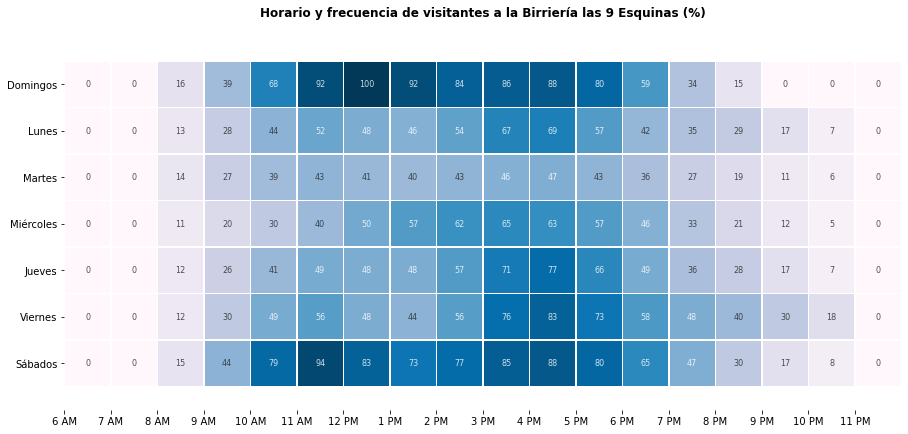

In [36]:
plt.figure(figsize=(15,7))
sns.heatmap(base_resto, cmap='PuBu', linewidths=0.8, annot=True, annot_kws={'fontsize':8, 'alpha':0.8}, fmt='d', square=True,
           cbar=False)

plt.xticks(np.arange(18), list(base_resto))
plt.title('Horario y frecuencia de visitantes a la Birrier칤a las 9 Esquinas (%)\n', weight='semibold')

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);
plt.show()

Gracias a Popular Times de Google Maps descubrimos que la Birrier칤a las 9 Esquinas esta abierto todos los d칤as y basado en la frecuencia de sus visitantes pienso que es posible disfrutar de un excelente almuerzo en los d칤as de la semana ya que los fines de semana parece estar congestionado de clientes a menos que pueda considerar ir a una cena el cual tiene una frecuencia de visitas menor que al mediod칤a

Como puede verse estos datos ofrecen un potencial genial para hacer an치lisis del comportamiento de los competidores as칤 como tambien para conocer los patrones de los clientes no s칩lo al sector tur칤stico sino a cualquier sector de comercio y servicios.

De hecho puedes ver un ejemplo de ello en uno de mis post, esta vez para Ciudad de M칠xico donde analizamos espacialmente Google Maps Popular Times <a href="http://roqueleal.me/big-data/popular-times-mexico.html">Disponible aqui</a>

# Donde se encuentran los atractivos tur칤sticos de la ciudad de Guadalajara y cu치les son los horarios m치s frecuentados

![title](https://assets-fl-uploads.reservamos.mx/uploads/bg/city%3Aguadalajara/cover_desktop_uploads_2F1499977933533-c8835yqvzil-799cb6f66f348d788b37e82f1c2c02fe_2FCover-Guadalajara_2.jpg)

# Extraemos los datos de las atracciones tur칤sticas ubicadas en el centro de la ciudad de Guadalajara y los analizamos

## Vamos analizar los datos obtenidos y encontrar el mejor horario para visitarlos

In [38]:
HL = pd.read_csv('gdl_touristes.csv')

In [57]:
HL.shape

(120, 9)

In [39]:
HL.total_ratings = HL.total_ratings.replace('\(|\)|,', '', regex=True)

In [40]:
HL.total_ratings = HL.total_ratings.astype(float)

In [41]:
HL10 = HL.sort_values(by='total_ratings', ascending=False).head(50).copy()

In [42]:
HL10.head(20)

full_name  rating  total_ratings  \
5          Mercado Libertad - San Juan de Dios     4.3        51704.0   
3                        Zoologico Guadalajara     4.7        35357.0   
0                        Guadalajara Cathedral     4.8        27296.0   
27                             Revolution Park     4.3        24581.0   
43         Parque Metropolitano de Guadalajara     4.7        22146.0   
9                             Hospicio Caba침as     4.8        15866.0   
21             Basilica of Our Lady of Zapopan     4.8        14824.0   
13                              Acuario Michin     4.5        13212.0   
1   Templo Expiatorio del Sant칤simo Sacramento     4.8        11945.0   
10                          Bosque Los Colomos     4.8        11851.0   
15                            Parque Agua Azul     4.4        11528.0   
41                                Morelos Park     3.9        10756.0   
4                            Liberation Square     4.6         9439.0   
40                             Solidarity Park     4.2         9437.0   
48                              Jard칤n Hidalgo     4.7         8375.0   
23                              Parque Alcalde     4.5         8148.0   
42                      Plaza de los Mariachis     4.0         7989.0   
89                                Selva M치gica     4.3         7930.0   
32                           Parque San Rafael     4.5         6484.0   
17                               Plaza Tapat칤a     4.6         6479.0   

   landmark_category                                        description  \
5             Market  Sprawling indoor market with stalls selling fo...   
3                Zoo  Popular zoo featuring a wide range of animals,...   
0          Cathedral  This grand cathedral housing the relics of St....   
27              Park                                                NaN   
43        State park  Popular city park with 100+ hectares of green ...   
9    Cultural center  This famous 18th-century complex, designed to ...   
21          Basilica  Baroque-style Franciscan complex with an ornat...   
13          Aquarium                                                NaN   
1    Catholic church  Historic church with notable features includin...   
10   National forest  Bucolic city park with walking paths, picnic a...   
15              Park  Sizable green space featuring an outdoor theat...   
41              Park  Large public park known for its Day of the Dea...   
4              Plaza                                                NaN   
40              Park                                                NaN   
48            Garden  Lush, landscaped central square with a statue ...   
23              Park  Public green space featuring play equipment, a...   
42          Landmark  Charming square in the city center known for i...   
89    Amusement park                                                NaN   
32              Park  Big park with many recreation options, includi...   
17          Monument  Spacious plaza featuring a sculpture inspired ...   

                                              address  \
5   Calle Dionisio Rodr칤guez 52, La Perla, 44360 G...   
3   Calle Paseo del Zool칩gico 600, Huentit치n El Al...   
0   Av. Fray Antonio Alcalde 10, Zona Centro, 4410...   
27  Calz. del Federalismo Sur 2183, Col Americana,...   
43  Avenida Beethoven Parque Metropolitano de Guad...   
9   Calle Caba침as 8, Las Fresas, 44360 Guadalajara...   
21  Calle Eva Brise침o 152, Zapopan, 44250 Zapopan,...   
13  Mariano de la B치rcena 990, Zona Centro, 44200 ...   
1   Calle Manuel L칩pez Cotilla 935, Col Americana,...   
10  El Chaco, 3200, Providencia, 44630 Guadalajara...   
15  Calz Independencia Sur 973, Centro, 44100 Guad...   
41  Calz Independencia Nte, Zona Centro, 44100 Gua...   
4   Calle Pedro Loza 27A, Zona Centro, 44100 Guada...   
40  Av. Malec칩n 300, Benito Ju치rez, 44770 Guadalaj...   
48  Guillermo Prieto S/N, Centro, 45500 San Pedro ...   
23  Calle Jes칰s

In [43]:
HL10.shape

(50, 9)

## Para este ejercicio vamos analizar de la muestra las 50 mejores atracciones tur칤sticas que nos ofrece la ciudad

In [44]:
tourisme_map = folium.Map(location=gdl_center, zoom_start=14, tiles=tileset, attr=attribution)

for latitude, longitude, full_name, rating, total_rating in zip(HL10.latitude, HL10.longitude, HL10.full_name, HL10.rating, HL10.total_ratings):
    popup = '<strong>' + str(full_name) +  '</li><li>Rating: ' + str(rating) + ' (Total of ' + str(total_rating) + ' reviews)'
    folium.Marker( [latitude, longitude], 
                   icon=folium.CustomIcon( icon_image='https://www.pinclipart.com/picdir/big/46-460577_maps-vector-graphic-google-maps-icon-android-clipart.png', icon_size=(15,15) ), popup=popup).add_to(tourisme_map)
tourisme_map

In [45]:
tourisme_rating = HL10[HL10.total_ratings>10000].copy()
tourisme_rating['count'] = 1

## Ordenamos las mejores atracciones y localicemos los registros en un mapa de calor

In [46]:
tourisme_rating.head(50)

full_name  rating  total_ratings  \
5          Mercado Libertad - San Juan de Dios     4.3        51704.0   
3                        Zoologico Guadalajara     4.7        35357.0   
0                        Guadalajara Cathedral     4.8        27296.0   
27                             Revolution Park     4.3        24581.0   
43         Parque Metropolitano de Guadalajara     4.7        22146.0   
9                             Hospicio Caba침as     4.8        15866.0   
21             Basilica of Our Lady of Zapopan     4.8        14824.0   
13                              Acuario Michin     4.5        13212.0   
1   Templo Expiatorio del Sant칤simo Sacramento     4.8        11945.0   
10                          Bosque Los Colomos     4.8        11851.0   
15                            Parque Agua Azul     4.4        11528.0   
41                                Morelos Park     3.9        10756.0   

   landmark_category                                        description  \
5             Market  Sprawling indoor market with stalls selling fo...   
3                Zoo  Popular zoo featuring a wide range of animals,...   
0          Cathedral  This grand cathedral housing the relics of St....   
27              Park                                                NaN   
43        State park  Popular city park with 100+ hectares of green ...   
9    Cultural center  This famous 18th-century complex, designed to ...   
21          Basilica  Baroque-style Franciscan complex with an ornat...   
13          Aquarium                                                NaN   
1    Catholic church  Historic church with notable features includin...   
10   National forest  Bucolic city park with walking paths, picnic a...   
15              Park  Sizable green space featuring an outdoor theat...   
41              Park  Large public park known for its Day of the Dea...   

                                              address  \
5   Calle Dionisio Rodr칤guez 52, La Perla, 44360 G...   
3   Calle Paseo del Zool칩gico 600, Huentit치n El Al...   
0   Av. Fray Antonio Alcalde 10, Zona Centro, 4410...   
27  Calz. del Federalismo Sur 2183, Col Americana,...   
43  Avenida Beethoven Parque Metropolitano de Guad...   
9   Calle Caba침as 8, Las Fresas, 44360 Guadalajara...   
21  Calle Eva Brise침o 152, Zapopan, 44250 Zapopan,...   
13  Mariano de la B치rcena 990, Zona Centro, 44200 ...   
1   Calle Manuel L칩pez Cotilla 935, Col Americana,...   
10  El Chaco, 3200, Providencia, 44630 Guadalajara...   
15  Calz Independencia Sur 973, Centro, 44100 Guad...   
41  Calz Independencia Nte, Zona Centro, 44100 Gua...   

                                                hours   latitude   longitude  \
5   ['0% busy at 6 AM.', '0% busy at 7 AM.', '4% b...  20.675439 -103.339998   
3                                                  []  20.726974 -103.308494   
0   ['0% busy at 6 AM.', '1% busy at 7 AM.', '6% b...  20.677034 -103.346984   
27                                                 []  20.675047 -103.355879   
43  ['0% busy at 5 AM.', '3% busy at 6 AM.', '10% ...  20.671245 -103.438344   
9   ['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...  20.676936 -103.337497   
21                                                 []  20.721266 -103.392145   
13                                                 []  20.692824 -103.351358   
1                                                  []  20.673695 -103.358967   
10  ['0% busy at 6 AM.', '11% busy at 7 AM.', '24%...  20.708722 -103.393593   
15                                                 []  20.659577 -103.348194   
41  ['0% busy at 4 AM.', '1% busy at 5 AM.', '2% b...  20.679850 -103.340030   

    count  
5       1  
3       1  
0       1  
27      1  
43      1  
9       1  
21      1  
13      1  
1       1  
10      1  
15      1  
41      1

In [47]:
from folium import plugins
from folium.plugins import HeatMap
HeatMap(data=tourisme_rating[['latitude', 'longitude', 'total_ratings']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=20, max_zoom=17).add_to(tourisme_map)
tourisme_map

## Vamos a conocer el mejor horario para visitar el Mercado Libertad de Guadalajara

In [48]:
str(list(HL10[HL10.full_name == 'Mercado Libertad - San Juan de Dios'].hours))

'["[\'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'4% busy at 8 AM.\', \'13% busy at 9 AM.\', \'30% busy at 10 AM.\', \'51% busy at 11 AM.\', \'68% busy at 12 PM.\', \'79% busy at 1 PM.\', \'83% busy at 2 PM.\', \'79% busy at 3 PM.\', \'64% busy at 4 PM.\', \'41% busy at 5 PM.\', \'20% busy at 6 PM.\', \'7% busy at 7 PM.\', \'0% busy at 8 PM.\', \'0% busy at 9 PM.\', \'0% busy at 10 PM.\', \'0% busy at 11 PM.\', \'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'4% busy at 8 AM.\', \'12% busy at 9 AM.\', \'25% busy at 10 AM.\', \'39% busy at 11 AM.\', \'49% busy at 12 PM.\', \'55% busy at 1 PM.\', \'60% busy at 2 PM.\', \'61% busy at 3 PM.\', \'57% busy at 4 PM.\', \'52% busy at 5 PM.\', \'40% busy at 6 PM.\', \'19% busy at 7 PM.\', \'0% busy at 8 PM.\', \'0% busy at 9 PM.\', \'0% busy at 10 PM.\', \'0% busy at 11 PM.\', \'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'4% busy at 8 AM.\', \'13% busy at 9 AM.\', \'25% busy at 10 AM.\', \'37% busy at 11 AM.\', \'44% busy at 12 PM.\', \'49% busy a

In [49]:
def visit_planner(place_name) :


    place_name = pd.DataFrame(index=['Domingos', 'Lunes', 'Martes', 'Mi칠rcoles', 'Jueves', 'Viernes', 'S치bados'], \
                              columns=['6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM','3 PM',
                                       '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'])    
    

    return place_name

In [50]:
base = visit_planner('Mercado Libertad - San Juan de Dios')
base

6 AM 7 AM 8 AM 9 AM 10 AM 11 AM 12 PM 1 PM 2 PM 3 PM 4 PM 5 PM 6 PM  \
Domingos   NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Lunes      NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Martes     NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Mi칠rcoles  NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Jueves     NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Viernes    NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
S치bados    NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   

          7 PM 8 PM 9 PM 10 PM 11 PM  
Domingos   NaN  NaN  NaN   NaN   NaN  
Lunes      NaN  NaN  NaN   NaN   NaN  
Martes     NaN  NaN  NaN   NaN   NaN  
Mi칠rcoles  NaN  NaN  NaN   NaN   NaN  
Jueves     NaN  NaN  NaN   NaN   NaN  
Viernes    NaN  NaN  NaN   NaN   NaN  
S치bados    NaN  NaN  NaN   NaN   NaN

In [51]:
for hour in list(base):
    base[hour] = re.findall('...%.{0,20} '+str(hour), str(list(HL10[HL10.full_name=='Mercado Libertad - San Juan de Dios'].hours)))
    base[hour] = [ re.findall('\d+', str(i))[0] for i in base[hour] ]
    base[hour] = base[hour].astype(int)

In [52]:
base

6 AM  7 AM  8 AM  9 AM  10 AM  11 AM  12 PM  1 PM  2 PM  3 PM  \
Domingos      0     0     4    13     30     51     68    79    83    79   
Lunes         0     0     4    12     25     39     49    55    60    61   
Martes        0     0     4    13     25     37     44    49    54    53   
Mi칠rcoles     0     0     4    10     20     30     39    43    46    47   
Jueves        0     0     5    12     24     37     47    53    58    60   
Viernes       0     0     6    15     28     43     53    59    63    66   
S치bados       0     0     6    18     36     55     72    86    96   100   

           4 PM  5 PM  6 PM  7 PM  8 PM  9 PM  10 PM  11 PM  
Domingos     64    41    20     7     0     0      0      0  
Lunes        57    52    40    19     0     0      0      0  
Martes       49    42    30    14     0     0      0      0  
Mi칠rcoles    45    38    28    16     0     0      0      0  
Jueves       58    50    37    21     0     0      0      0  
Viernes      65    56    40    24     0     0      0      0  
S치bados      96    81    57    32     0     0      0      0

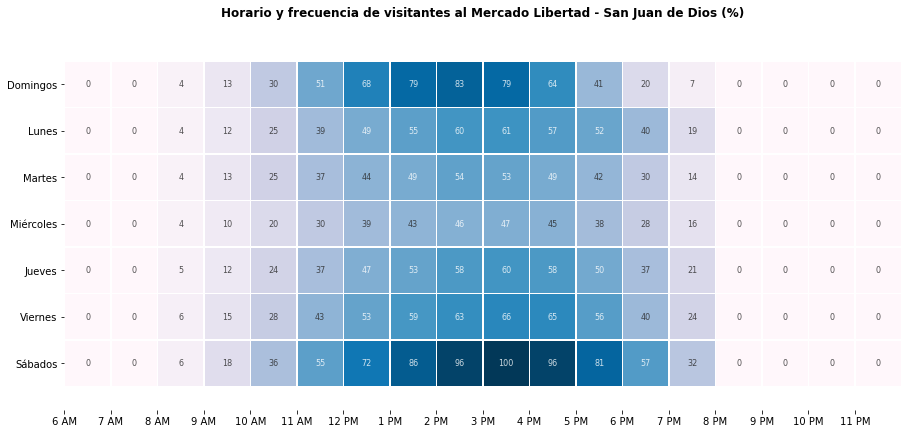

In [56]:
plt.figure(figsize=(15,7))
sns.heatmap(base, cmap='PuBu', linewidths=0.8, annot=True, annot_kws={'fontsize':8, 'alpha':0.8}, fmt='d', square=True,
           cbar=False)

plt.xticks(np.arange(18), list(base))
plt.title('Horario y frecuencia de visitantes al Mercado Libertad - San Juan de Dios (%)\n', weight='semibold')

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);
plt.show()

### Parece que en los d칤as de semana es una mejor opci칩n para visitar nuestro mercado 

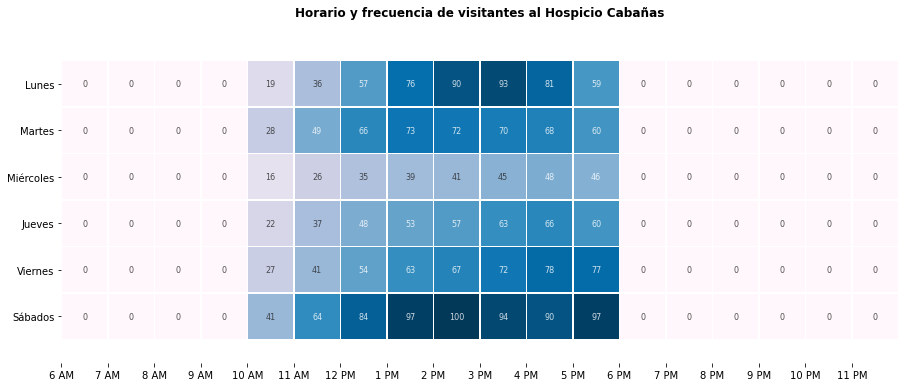

In [55]:
hospicio = visit_planner("Hospicio Caba침as")

hospicio.drop('Domingos', axis=0, inplace=True)

for hour in list(hospicio):
    hospicio[hour] = re.findall('...%.{0,20} '+str(hour), str(list(HL10[HL10.full_name=="Hospicio Caba침as"].hours)))
    hospicio[hour] = [ re.findall('\d+', str(i))[0] for i in hospicio[hour] ]
    hospicio[hour] = hospicio[hour].astype(int)

plt.figure(figsize=(15,7))
sns.heatmap(hospicio, cmap='PuBu', linewidths=0.8, annot=True, annot_kws={'fontsize':8, 'alpha':0.8}, fmt='d', square=True,
           cbar=False)

plt.xticks(np.arange(18), list(base))
plt.title("Horario y frecuencia de visitantes al Hospicio Caba침as\n", weight='semibold')

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);
plt.show()

## Tambien podemos ver el mejor horario para visitar el Hospicio Caba침as, los d칤as s치bados no son una buena opci칩n pero un mi칠rcoles en la ma침ana ser치 un horario ideal para visitarlo

## Conclusiones

Desde el punto de vista de location intelligence para la gesti칩n del destino tur칤stico, las t칠cnicas empleadas permiten identificar y localizar con toda claridad aquellos servicios, establecimientos y agentes interesados que contribuyen a mejorar la imagen y la competitividad de la ciudad de Guadalajara como destino tur칤stico y gastron칩mico.

En el campo de las implicaciones gerenciales, los resultados generados utilizando Google Maps y Popular Times nos dan una opci칩n 칠ficaz para establecer acuerdos B2B para la mejora general de la calidad de los servicios y crear una experiencia de viaje envolvente unida a tecnolog칤as de marketing de proximidad. Por otra parte, su aplicaci칩n tambi칠n permite identificar la frecuencia en la cual los locales y/o atracciones son visitados, la competencia, su popularidad y los t칩picos por los cuales son reconocidos en funci칩n de las recomendaciones de los usuarios.

Finalmente gracias a los resultados es posible aplicar estas t칠cnicas a cualquier destino del mundo y a cualquier sector, por ejemplo conocer los horarios de congestionamientos en bancos, consultorios m칠dicos, retail, etc, aunque es un requisito indispensable que el destino estudiado cuente con una presencia sustancial en Google Maps y que su afluencia de visitantes genere las interacciones suficientes para ser analizadas mediante la ciencia de datos.

## 游녨游녨 <center> <a href="https://www.linkedin.com/in/lealrlx/">Te invito a escribirme tus ideas, tus comentarios y sobre todo compartir tus opiniones游깴 </a> </center>##